In [1]:
import glob
import numpy as np
import pandas as pd
import gcsfs

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import matplotlib
font = {'family' : 'sans-serif',
        'weight': 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

In [9]:
BASE_BUCKET_PATH = "gs://spaceml-lightning-severe-weather/"
RESULTS_PATH = os.path.join(BASE_BUCKET_PATH, "paper_results")
EVENT_PATH = os.path.join(BASE_BUCKET_PATH, "event_60min")
TEST_SET_DATA_PATH = os.path.join(RESULTS_PATH, "test_ds_times.csv")
DATA_10K_PATH = os.path.join(RESULTS_PATH , "10K_predictions.csv")

GLM_VARIABLES = [
    'flash_extent_density',
    'flash_centroid_density',
    'average_flash_area',
    'total_energy',
    'group_extent_density',
    'group_centroid_density',
    'average_group_area',
    'minimum_flash_area'
]

In [4]:
def get_sevtype(filename: str):
    '''
    From filename convention, return class type
    
    Args:
        filename: name of timeseries file
    '''
    if "tornado" in filename:
        return "tornado"
    elif "hail" in filename:
        return "hail"
    elif "null" in filename:
        return "null"

In [8]:
# Load test set data from bucket
test_set_files = pd.read_csv(TEST_SET_DATA_PATH, usecols=["file"])
# Convert Ivan's filename to bucket convention here
test_set_files["file"] = test_set_files["file"].apply(lambda x: x.replace("/home/jupyter/local_data/event_60min/", ))
test_set_files["sevtype"] = test_set_files["file"].apply(lambda x: get_sevtype(x)) # add class type
test_set_files.head()

,file,sevtype
0,../data/mount/event_60min/null/201905//66686_g...,null
1,../data/mount/event_60min/null/201905//67453_g...,null
2,../data/mount/event_60min/null/201905//68681_g...,null
3,../data/mount/event_60min/null/201905//66797_g...,null
4,../data/mount/event_60min/tornado/201906/7471_...,tornado


In [11]:
# Load predictions
test_predictions = pd.read_csv(DATA_10K_PATH, usecols=["probability", "ground_truth"])
test_predictions.head()

,probability,ground_truth
0,0.482680,0
1,0.035915,0
2,0.000008,0
3,0.209335,0
4,0.295053,1


In [12]:
def get_result(actual, prediction):
    '''
    Based on ground truth and our predictions,
    determine True positives, False negatives, etc.
    1 = severe event, 0 = null
    
    Ars:
        actual: ground truth
        prediction: predicted severe event
    '''
    if actual==1 and prediction==1:
        return "TP"
    elif actual==1 and prediction ==0:
        return "FN"
    elif actual==0 and prediction==0:
        return "TN"
    elif actual==0 and prediction==1:
        return "FP"

In [13]:
# Get predicted severe events from predicted probability
test_predictions["pred"] = test_predictions["probability"].apply(lambda x: 1 if x>=0.5 else 0)
# Add TP/TN/FP/FN column
test_predictions["result"] = test_predictions.apply(lambda row: get_result(row["ground_truth"], row["pred"]), axis=1)
test_predictions.head()

,probability,ground_truth,pred,result
0,0.482680,0,0,TN
1,0.035915,0,0,TN
2,0.000008,0,0,TN
3,0.209335,0,0,TN
4,0.295053,1,0,FN


In [14]:
# combine test set with predictions
test_set = pd.concat([test_set_files, test_predictions], axis=1)

In [15]:
# Group results by TP
grouped = test_set.groupby("result")
TP = grouped.get_group("TP")
FP = grouped.get_group("FP")
TN = grouped.get_group("TN")
FN = grouped.get_group("FN")

grouped.count()

,file,sevtype,probability,ground_truth,pred
result,,,,,
FN,57,57,57,57,57
FP,53,53,53,53,53
TN,167,167,167,167,167
TP,167,167,167,167,167


In [16]:
def load_event(filename):
    """
    load GLM timeseires event file
    """
    ts = pd.read_csv(filename, parse_dates=["start_time", "end_time"])
    return ts

In [17]:
def preprocess(df, norm_rows=None):
    """
    Preprocess GLM time series event file
    
    Args:
        df: timeseries dataframe
        norm_rows (int): number of rows to average over for normalization
    """
    # Convert times to "minutes before event" (-60 to 0)
    df["minutes_before"] = (df["end_time"].max() - df["start_time"])
    df["minutes_before"] = df["minutes_before"].apply(
        lambda x: np.round(x.total_seconds() / 60. * -1, 0)
    )
    df.sort_values("minutes_before", ascending=True)
    
    if norm_rows:
        norm_by_start(df, rows=norm_rows) # normalize by first n rows
    return df

In [18]:
def norm_by_start(df, rows=20):
    """
    Normalize time series by start of time series.
    Args:
        df: timeseries dataframe
        rows (int): number of rows at start of timeseris to normalize by
    """
    for col in GLM_VARIABLES:
        df[col+"_norm"] = df[col]/df[col][0:rows].mean(skipna=True)
    return df

In [19]:
def load_process_median(files):
    """
    Load GLM timeseries files, preprocess to format for comparison,
    and find the median timeseries..
    
    files (list): timeseries files
    """
    df_list = [preprocess(load_event(x), norm_rows=20) for x in files]
    df_concat = pd.concat(df_list)
    df_concat = df_concat.replace(np.inf, np.nan)
    #mean = df_concat.groupby("minutes_before").mean().reset_index()
    median = df_concat.groupby("minutes_before").median().reset_index()
    return median

In [20]:
# For each TP, FN, etc. find median timeseries
TP_med = load_process_median(TP["file"])
FP_med = load_process_median(FP["file"])
TN_med = load_process_median(TN["file"])
FN_med = load_process_median(FN["file"])

FileNotFoundError: [Errno 2] File ../data/mount/event_60min/hail/202006/7448_glm.csv does not exist: '../data/mount/event_60min/hail/202006/7448_glm.csv'

In [24]:
import string
letters = list(string.ascii_lowercase)

In [21]:
# Plot each of 4 median timeseries for each GLM quantity
order = ["TP", "TN", "FP", "FN"]
colors = ["b", "b", "r", "r"]
lstyles = ["-", "--", "-", "--"]
fig, ax = plt.subplots(2, 4, figsize=(30, 15))
for ax_i, var in enumerate(GLM_VARIABLES):
    row = ax_i//4
    col = ax_i%4
    ax[row, col].title.set_text(f"{letters[ax_i]}) {var.replace('_', ' ')}")
    for i, res in enumerate([TP_med, TN_med, FP_med, FN_med]):
        ax[row, col].plot(res["minutes_before"], res[var], color=colors[i], ls=lstyles[i], label=order[i])
    ax[row, col].set_xlabel("Minutes before event")
    if col ==0:
        ax[row, col].set_ylabel("Median value")
    if ax_i == 0:
        ax[row, col].legend()
plt.subplots_adjust(wspace=0.25, hspace=0.25)
#plt.savefig("../data/mount/results_paper/timeseries_results.png", dpi=200)                            
plt.show()

NameError: name 'letters' is not defined

In [27]:
# Group test data by severe type
sevtype_grouped = test_set.groupby("sevtype")
TOR = sevtype_grouped.get_group("tornado")
HAIL = sevtype_grouped.get_group("hail")
NULL = sevtype_grouped.get_group("null")

# Find median time series profiles each event type
TOR_med = load_process_median(TOR["file"])
HAIL_med = load_process_median(HAIL["file"])
NULL_med = load_process_median(NULL["file"])

sevtype_grouped.count()

,file,probability,ground_truth,pred,result
sevtype,,,,,
hail,175,175,175,175,175
null,220,220,220,220,220
tornado,49,49,49,49,49


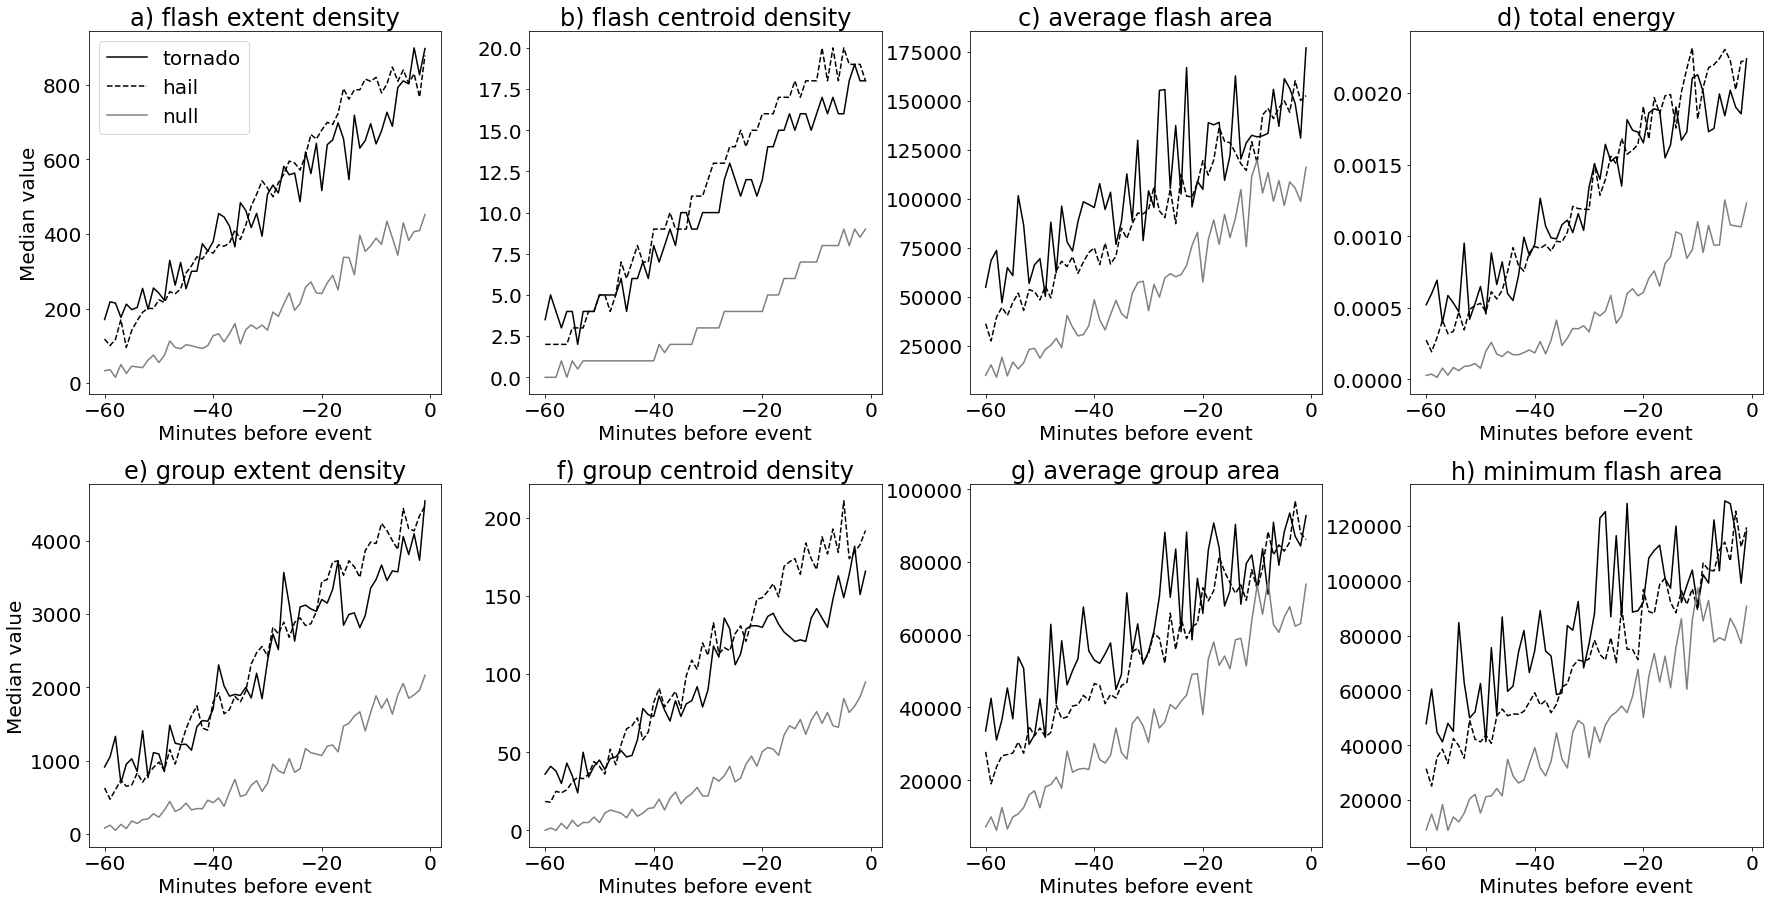

In [44]:
# Plot severe-type median time series
order = ["tornado", "hail", "null"]
colors = ["k", "k", "gray"]
lstyles = ["-", "--", "-"]
fig, ax = plt.subplots(2, 4, figsize=(30, 15))
for ax_i, var in enumerate(GLM_VARIABLES):
    row = ax_i//4
    col = ax_i%4
    ax[row, col].title.set_text(f"{letters[ax_i]}) {var.replace('_', ' ')}")
    for i, res in enumerate([TOR_med, HAIL_med, NULL_med]):
        ax[row, col].plot(res["minutes_before"], res[var], color=colors[i], ls=lstyles[i], label=order[i])
    ax[row, col].set_xlabel("Minutes before event")
    if col ==0:
        ax[row, col].set_ylabel("Median value")
    if ax_i == 0:
        ax[row, col].legend()
plt.subplots_adjust(wspace=0.25, hspace=0.25)
#plt.savefig("../data/mount/results_paper/timeseries_sevtype.png", dpi=400)
plt.show()